(Chapter 7: Nonlinear Valuation)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 7: Nonlinear Valuation


```{contents} Contents
:depth: 2
```



## rs_utility.py

In [1]:
from quantecon import compute_fixed_point
from quantecon.markov import tauchen

import numpy as np
from numba import njit
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("β", "θ", "ρ", "σ", "r", "x_vals", "P"))


def create_rs_utility_model(
        n=180,      # size of state space
        β=0.95,     # time discount factor
        ρ=0.96,     # correlation coef in AR(1)
        σ=0.1,      # volatility
        θ=-1.0):    # risk aversion
    mc = tauchen(n, ρ, σ, 0, 10)  # n_std = 10
    x_vals, P = mc.state_values, mc.P
    r = x_vals      # special case u(c(x)) = x
    return Model(β=β, θ=θ, ρ=ρ, σ=σ, r=r, x_vals=x_vals, P=P)


@njit
def K(v, model):
    β, θ, ρ, σ, r, x_vals, P = model
    return r + (β/θ) * np.log(np.dot(P, (np.exp(θ*v))))


def compute_rs_utility(model):
    β, θ, ρ, σ, r, x_vals, P = model
    v_init = np.zeros(len(x_vals))
    v_star = compute_fixed_point(lambda v: K(v, model), v_init,
                                 error_tol=1e-10, max_iter=1000, print_skip=25)
    return v_star


# Plots


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


def plot_v(savefig=False,
           figname="./figures/rs_utility_1.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_rs_utility_model()
    β, θ, ρ, σ, r, x_vals, P = model

    a = 1/(1 - (ρ*β))
    b = (β /(1 - β)) * (θ/2) * (a*σ)**2

    v_star = compute_rs_utility(model)
    v_star_a = a * x_vals + b
    ax.plot(x_vals, v_star, linewidth=2, alpha=0.7,
            label="approximate fixed point")
    ax.plot(x_vals, v_star_a, "k--", linewidth=2, alpha=0.7,
            label=r"$v(x)=ax + b$")
    ax.set_xlabel(r"$x$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def plot_multiple_v(savefig=False,
                    figname="./figures/rs_utility_2.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    σ_vals = 0.05, 0.1

    for σ in σ_vals:
        model = create_rs_utility_model(σ=σ)
        β, θ, ρ, σ, r, x_vals, P  = model
        v_star = compute_rs_utility(model)
        ax.plot(x_vals, v_star, linewidth=2, alpha=0.7,
                label=r"$\sigma=$" + f"{σ}")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$v(x)$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


Iteration    Distance       Elapsed (seconds)
---------------------------------------------


25           6.552e-01      1.088e+00         
50           1.657e-01      1.091e+00         
75           4.489e-02      1.094e+00         
100          1.237e-02      1.096e+00         
125          3.424e-03      1.099e+00         
150          9.492e-04      1.102e+00         
175          2.632e-04      1.105e+00         
200          7.302e-05      1.107e+00         
225          2.025e-05      1.110e+00         
250          5.618e-06      1.112e+00         
275          1.558e-06      1.115e+00         
300          4.323e-07      1.117e+00         
325          1.199e-07      1.120e+00         
350          3.326e-08      1.121e+00         
375          9.227e-09      1.122e+00         
400          2.559e-09      1.123e+00         
425          7.100e-10      1.124e+00         
450          1.969e-10      1.124e+00         
464          9.604e-11      1.125e+00         
Converged in 464 steps


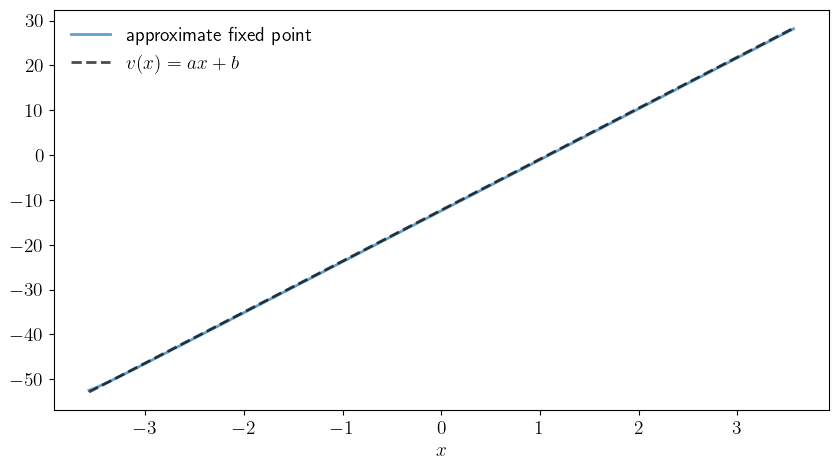

In [2]:
plot_v()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           2.636e-01      3.805e-03         
50           5.190e-02      6.443e-03         
75           1.235e-02      9.102e-03         
100          3.222e-03      1.179e-02         
125          8.734e-04      1.441e-02         
150          2.402e-04      1.689e-02         
175          6.643e-05      1.942e-02         
200          1.841e-05      2.208e-02         
225          5.104e-06      2.442e-02         
250          1.416e-06      2.565e-02         
275          3.927e-07      2.649e-02         
300          1.089e-07      2.738e-02         
325          3.021e-08      2.820e-02         
350          8.380e-09      2.901e-02         
375          2.325e-09      2.984e-02         
400          6.448e-10      3.066e-02         
425          1.789e-10      3.149e-02         
437          9.666e-11      3.189e-02         
Converged in 437 steps
Iteration    Distance       Elapsed (se

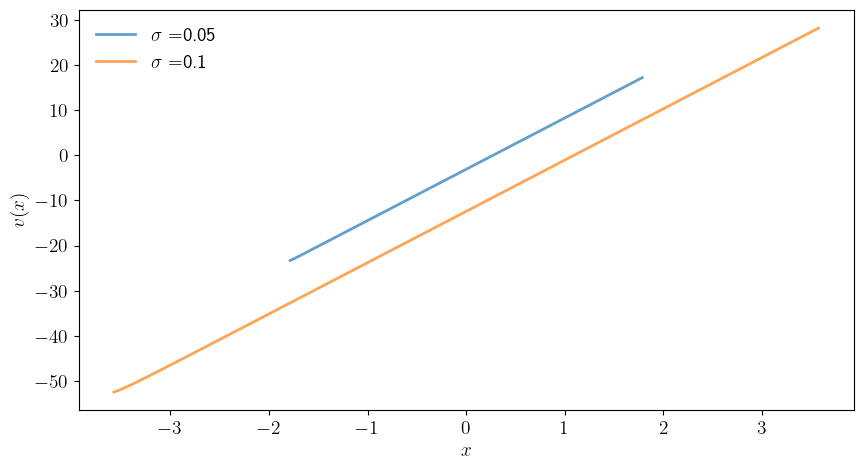

In [3]:
plot_multiple_v()

## ez_utility.py

In [4]:
"""
Epstein--Zin utility: solving the recursion for a given consumption
path.

"""

from quantecon import compute_fixed_point
from quantecon.markov import tauchen

import numpy as np
from numba import njit
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("β", "ρ", "σ", "α", "γ", "c", "x_vals", "P"))


def create_ez_utility_model(
        n=200,      # size of state space
        ρ=0.96,     # correlation coef in AR(1)
        σ=0.1,      # volatility
        β=0.99,     # time discount factor
        α=0.75,     # EIS parameter
        γ=-2.0):    # risk aversion parameter
    mc = tauchen(n, ρ, σ, 0, 5)
    x_vals, P = mc.state_values, mc.P
    c = np.exp(x_vals)
    return Model(β=β, ρ=ρ, σ=σ, α=α, γ=γ, c=c, x_vals=x_vals, P=P)


@njit
def K(v, model):
    β, ρ, σ, α, γ, c, x_vals, P = model
    R = np.dot(P, v**γ)**(1/γ)
    return ((1 - β) * c**α + β * R**α)**(1/α)


def compute_ez_utility(model):
    v_init = np.ones(len(model.x_vals))
    v_star = compute_fixed_point(lambda v: K(v, model), v_init,
                                 error_tol=1e-6, max_iter=1000, print_skip=100)
    return v_star



# Plots


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


def plot_convergence(savefig=False,
                     num_iter=100,
                     figname="./figures/ez_utility_c.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_ez_utility_model()
    β, ρ, σ, α, γ, c, x_vals, P = model


    v_star = compute_ez_utility(model)
    v = 0.1 * v_star
    ax.plot(x_vals, v, "k-", linewidth=3, alpha=0.7, label=r"$v_0$")

    greys = [str(g) for g in np.linspace(0.0, 0.4, num_iter)]
    greys.reverse()

    for g in greys:
        ax.plot(x_vals, v, "k-", linewidth=1, alpha=0.7)
        for t in range(20):
            v = K(v, model)

    v_star = compute_ez_utility(model)
    ax.plot(x_vals, v_star, linewidth=3, alpha=0.7, label=r"$v^*$")
    ax.set_xlabel(r"$x$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def plot_v(savefig=False,
           figname="./figures/ez_utility_1.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_ez_utility_model()
    β, ρ, σ, α, γ, c, x_vals, P = model
    v_star = compute_ez_utility(model)
    ax.plot(x_vals, v_star, linewidth=2, alpha=0.7, label=r"$v^*$")
    ax.set_xlabel(r"$x$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def vary_gamma(gamma_vals=[1.0, -8.0],
               savefig=False,
               figname="./figures/ez_utility_2.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))

    for γ in gamma_vals:
        model = create_ez_utility_model(γ=γ)
        β, ρ, σ, α, γ, c, x_vals, P = model
        v_star = compute_ez_utility(model)
        ax.plot(x_vals, v_star, linewidth=2, alpha=0.7, label=r"$\gamma=$" + f"{γ}")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$v(x)$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def vary_alpha(alpha_vals=[0.5, 0.6],
               savefig=False,
               figname="./figures/ez_utility_3.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))

    for α in alpha_vals:
        model = create_ez_utility_model(α=α)
        β, ρ, σ, α, γ, c, x_vals, P = model
        v_star = compute_ez_utility(model)
        ax.plot(x_vals, v_star, linewidth=2, alpha=0.7, label=r"$\alpha=$"+f"{α}")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$v(x)$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


Iteration    Distance       Elapsed (seconds)
---------------------------------------------


100          1.790e-04      4.081e-01         
200          4.296e-05      4.211e-01         
300          1.660e-05      4.354e-01         
400          6.320e-06      4.452e-01         
500          2.406e-06      4.506e-01         
591          9.992e-07      4.553e-01         
Converged in 591 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
100          1.790e-04      4.147e-03         
200          4.296e-05      1.016e-02         
300          1.660e-05      1.422e-02         
400          6.320e-06      1.830e-02         
500          2.406e-06      2.235e-02         
591          9.992e-07      2.601e-02         
Converged in 591 steps


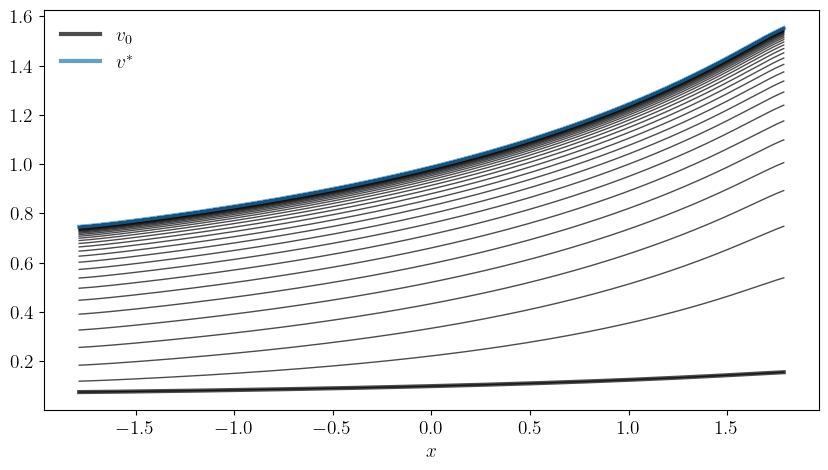

In [5]:
plot_convergence()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
100          1.790e-04      1.405e-02         
200          4.296e-05      2.629e-02         
300          1.660e-05      3.849e-02         
400          6.320e-06      5.100e-02         
500          2.406e-06      6.324e-02         
591          9.992e-07      7.454e-02         
Converged in 591 steps


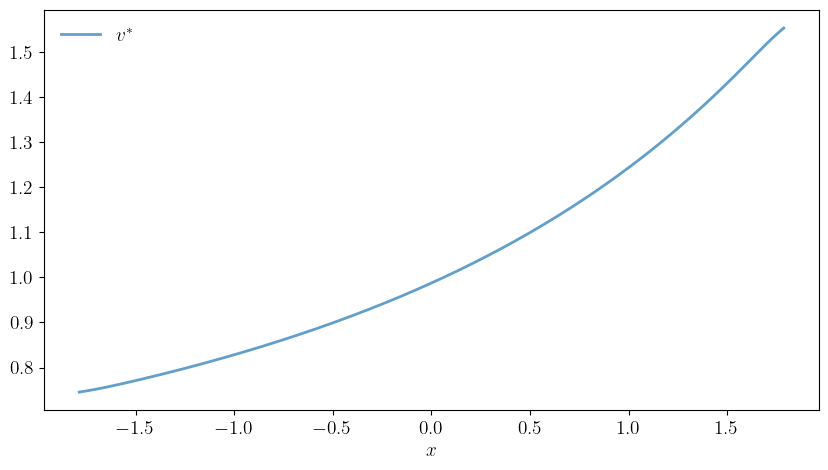

In [6]:
plot_v()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
100          3.700e-04      1.603e-02         
200          8.647e-05      2.859e-02         
300          3.125e-05      4.082e-02         
400          1.140e-05      5.296e-02         
500          4.156e-06      6.573e-02         
600          1.516e-06      7.824e-02         
642          9.921e-07      8.340e-02         
Converged in 642 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
100          6.104e-04      1.328e-02         
200          2.817e-04      2.545e-02         
300          1.147e-04      3.792e-02         
400          4.681e-05      5.001e-02         
500          1.912e-05      6.219e-02         
600          7.814e-06      6.804e-02         
700          3.194e-06      7.272e-02         
800          1.306e-06      7.728e-02         
830          9.985e-07      7.865e-02         
Converged in 830 steps


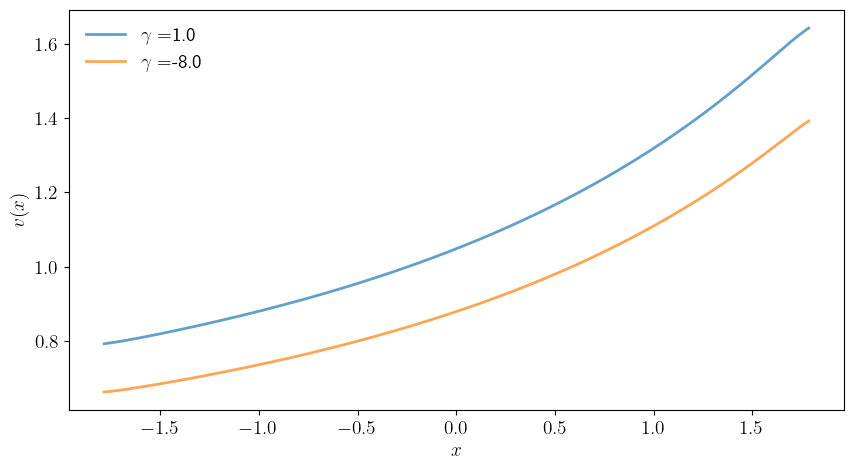

In [7]:
vary_gamma()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
100          1.989e-04      1.328e-02         
200          6.184e-05      2.549e-02         
300          2.346e-05      3.805e-02         
400          8.796e-06      5.074e-02         
500          3.299e-06      6.303e-02         
600          1.237e-06      7.570e-02         
622          9.972e-07      7.856e-02         
Converged in 622 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
100          1.917e-04      1.200e-02         
200          5.408e-05      1.746e-02         
300          2.066e-05      2.154e-02         
400          7.793e-06      2.556e-02         
500          2.940e-06      2.959e-02         
600          1.109e-06      3.371e-02         
611          9.962e-07      3.417e-02         
Converged in 611 steps


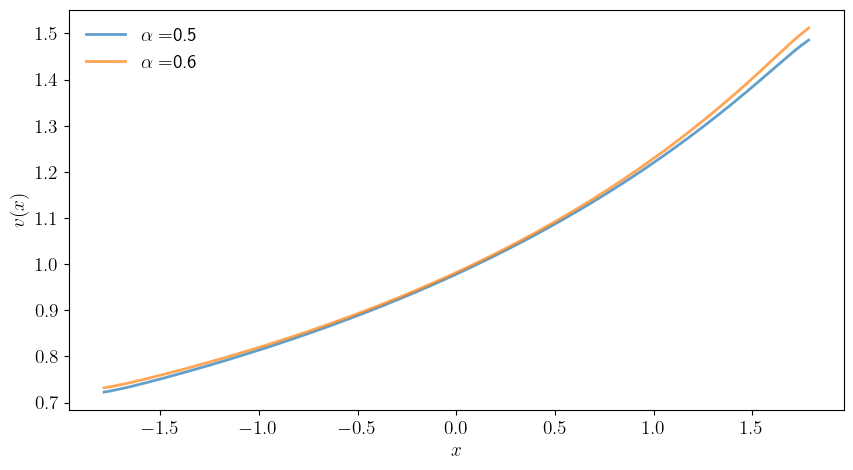

In [8]:
vary_alpha()